In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models



In [9]:
# --- Data Loading and Preprocessing ---
def load_and_prepare_data(path="ratings.csv"):
    df = pd.read_csv(path)
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()

    df["user"] = user_encoder.fit_transform(df["UserID"])
    df["item"] = item_encoder.fit_transform(df["MovieID"])
    df = df[["user", "item", "Rating"]]

    return df, df["user"].nunique(), df["item"].nunique()



In [3]:
# --- Model Builders ---
def build_cnn_model(num_users, num_items, embedding_dim=50):
    user_input = layers.Input(shape=(1,))
    item_input = layers.Input(shape=(1,))

    user_embedding = layers.Embedding(num_users, embedding_dim)(user_input)
    item_embedding = layers.Embedding(num_items, embedding_dim)(item_input)

    merged = layers.Concatenate(axis=1)([user_embedding, item_embedding])
    conv = layers.Conv1D(32, kernel_size=1, activation='relu')(merged)
    flat = layers.Flatten()(conv)
    dense = layers.Dense(64, activation='relu')(flat)
    output = layers.Dense(1)(dense)

    model = models.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model



In [4]:
def build_rnn_model(num_users, num_items, embedding_dim=50):
    user_input = layers.Input(shape=(1,))
    item_input = layers.Input(shape=(1,))

    user_embedding = layers.Embedding(num_users, embedding_dim)(user_input)
    item_embedding = layers.Embedding(num_items, embedding_dim)(item_input)

    sequence = layers.Concatenate(axis=1)([user_embedding, item_embedding])
    rnn = layers.SimpleRNN(64)(sequence)
    dense = layers.Dense(64, activation='relu')(rnn)
    output = layers.Dense(1)(dense)

    model = models.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model



In [5]:
# --- Evaluation Function ---
def evaluate(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    return rmse, mae



Epoch 1/5
316/316 - 5s - 15ms/step - loss: 1.9374
Epoch 2/5
316/316 - 2s - 8ms/step - loss: 0.7193
Epoch 3/5
316/316 - 3s - 8ms/step - loss: 0.6881
Epoch 4/5
316/316 - 2s - 6ms/step - loss: 0.6744
Epoch 5/5
316/316 - 3s - 11ms/step - loss: 0.6648
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/5
316/316 - 5s - 15ms/step - loss: 1.7345
Epoch 2/5
316/316 - 2s - 7ms/step - loss: 0.7198
Epoch 3/5
316/316 - 3s - 10ms/step - loss: 0.6862
Epoch 4/5
316/316 - 5s - 14ms/step - loss: 0.6708
Epoch 5/5
316/316 - 3s - 8ms/step - loss: 0.6610
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN RMSE: 0.8857, MAE: 0.6812
RNN RMSE: 0.8839, MAE: 0.6753


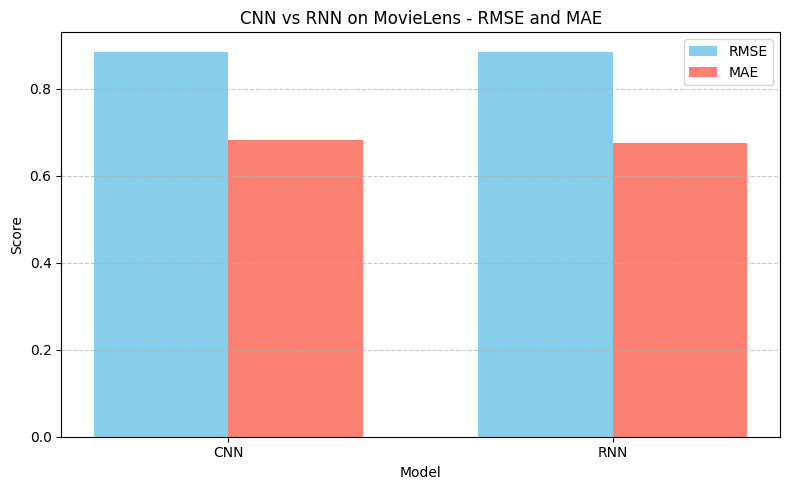

In [8]:
# --- Main Script Execution ---
if __name__ == "__main__":
    # Load and preprocess data
    ratings, num_users, num_items = load_and_prepare_data()
    train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

    # Train and evaluate CNN model
    cnn_model = build_cnn_model(num_users, num_items)
    cnn_model.fit([train_data.user, train_data.item], train_data.Rating, epochs=5, batch_size=256, verbose=2)
    cnn_preds = cnn_model.predict([test_data.user, test_data.item])
    cnn_rmse, cnn_mae = evaluate(test_data.Rating, cnn_preds)

    # Train and evaluate RNN model
    rnn_model = build_rnn_model(num_users, num_items)
    rnn_model.fit([train_data.user, train_data.item], train_data.Rating, epochs=5, batch_size=256, verbose=2)
    rnn_preds = rnn_model.predict([test_data.user, test_data.item])
    rnn_rmse, rnn_mae = evaluate(test_data.Rating, rnn_preds)

    # Print results
    print(f"CNN RMSE: {cnn_rmse:.4f}, MAE: {cnn_mae:.4f}")
    print(f"RNN RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}")

    # Plotting Results
    models_list = ['CNN', 'RNN']
    rmse_values = [cnn_rmse, rnn_rmse]
    mae_values = [cnn_mae, rnn_mae]

    x = np.arange(len(models_list))
    bar_width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x, rmse_values, width=bar_width, label='RMSE', color='skyblue')
    plt.bar(x + bar_width, mae_values, width=bar_width, label='MAE', color='salmon')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('CNN vs RNN on MovieLens - RMSE and MAE')
    plt.xticks(x + bar_width / 2, models_list)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
